In [ ]:
# 1. Import libraries

import pandas as pd
import numpy as np

# Load the dataset from the Excel file
df = pd.read_excel("mozambique_2012_2023_quarterly_merged.xlsx")

# Display the first five rows of the data
print(df.head())


   Period      GDP (MZN)  PensionFundAssets (MZN)  PensionContributions (MZN)  \
0  2012Q1  473491.595579                   137.74                       93.75   
1  2012Q2  473491.595579                   137.74                       93.75   
2  2012Q3  473491.595579                   137.74                       93.75   
3  2012Q4  473491.595579                   137.74                       93.75   
4  2013Q1  517732.700350                   301.70                      168.90   

   Inflation (%)  InterestRate (%)  FinancialSectorGDP (MZN)  
0            2.6              2.25              19905.699336  
1            2.6              2.25              19905.699336  
2            2.6              2.25              19905.699336  
3            2.6              2.25              19905.699336  
4            4.3              1.50              25613.456339  


In [ ]:
#2. Clean the Data

# Remove whitespace from column names
df.columns = df.columns.str.replace(' ', '')

# Convert "Period" to a quarterly PeriodIndex and set as index
df['Period'] = pd.PeriodIndex(df['Period'], freq='Q')
df = df.set_index('Period')

# Verify cleaned column names and index
print("Columns:", df.columns.tolist())
print("Index example:", df.index[0], "to", df.index[-1])


Columns: ['GDP(MZN)', 'PensionFundAssets(MZN)', 'PensionContributions(MZN)', 'Inflation(%)', 'InterestRate(%)', 'FinancialSectorGDP(MZN)']
Index example: 2012Q1 to 2023Q1


In [ ]:
#3. Indentify Total vs Average Variables

totals = ['GDP(MZN)', 'FinancialSectorGDP(MZN)', 
          'PensionFundAssets(MZN)', 'PensionContributions(MZN)']
averages = ['Inflation(%)', 'InterestRate(%)']
print("Totals (annual aggregates):", totals)
print("Averages (period rates):", averages)


Totals (annual aggregates): ['GDP(MZN)', 'FinancialSectorGDP(MZN)', 'PensionFundAssets(MZN)', 'PensionContributions(MZN)']
Averages (period rates): ['Inflation(%)', 'InterestRate(%)']


In [ ]:
#4. Denton INterpolation for Pension FUnd Assets (Quarterly Distribution)
# Annual totals for PensionFundAssets (from Q4 each year)
pfa_annual = df['PensionFundAssets(MZN)'].resample('Y', kind='period').last()

# Distribute each annual total of PFA into quarters proportional to that year's quarterly GDP
for year in pfa_annual.index.year:
    if year > 2022:  # we have data up to 2022 for PFA
        break
    annual_value = pfa_annual.loc[pd.Period(str(year), freq='Y')]
    # GDP for that year by quarter
    gdp_q = df.loc[f'{year}Q1':f'{year}Q4', 'GDP(MZN)']    
    total_gdp = gdp_q.sum()
    if total_gdp > 0:
        # proportional allocation
        df.loc[str(year), 'PensionFundAssets(MZN)'] = (gdp_q / total_gdp) * annual_value
    else:
        # if GDP total is zero (not the case here), split evenly
        df.loc[f'{year}Q1':f'{year}Q4', 'PensionFundAssets(MZN)'] = annual_value / 4.0

# Example: Show distributed PensionFundAssets for 2017
print(df.loc['2017Q1':'2017Q4', 'PensionFundAssets(MZN)'])


Period
2017Q1    2309.624481
2017Q2    2481.607541
2017Q3    2311.375282
2017Q4    2434.392696
Freq: Q-DEC, Name: PensionFundAssets(MZN), dtype: float64


C:\Users\lduma\AppData\Local\Temp\ipykernel_21976\2468224239.py:3: FutureWarning: The 'kind' keyword in Series.resample is deprecated and will be removed in a future version. Explicitly cast the index to the desired type instead
  pfa_annual = df['PensionFundAssets(MZN)'].resample('Y', kind='period').last()
C:\Users\lduma\AppData\Local\Temp\ipykernel_21976\2468224239.py:3: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  pfa_annual = df['PensionFundAssets(MZN)'].resample('Y', kind='period').last()


In [ ]:
#5. Chow-Lin Interpolation for Pension Contributions(Quarterly Distribution)

import statsmodels.api as sm

years = range(2012, 2023)
gdp_ann = {}
fin_ann = {}

for year in years:
    mask = df.index.year == year
    quarters = df.loc[mask]
    if quarters.empty:
        print(f"Warning: No data for any quarter in {year}, skipping.")
        continue
    if year >= 2017:
        gdp_ann[year] = quarters['GDP(MZN)'].sum()
        fin_ann[year] = quarters['FinancialSectorGDP(MZN)'].sum()
    else:
        q4 = pd.Period(f"{year}Q4", freq='Q')
        if q4 in df.index:
            gdp_ann[year] = df.loc[q4, 'GDP(MZN)']
            fin_ann[year] = df.loc[q4, 'FinancialSectorGDP(MZN)']
        else:
            print(f"Warning: {year}Q4 missing, skipping year {year}.")
            continue

contrib_ann = df['PensionContributions(MZN)'].resample('A', kind='period').last()

# Only keep years present in all three annual series
valid_years = set(gdp_ann.keys()) & set(fin_ann.keys()) & set(contrib_ann.index.year)
reg_df = pd.DataFrame({
    'GDP_ann': pd.Series({y: gdp_ann[y] for y in valid_years}),
    'Fin_ann': pd.Series({y: fin_ann[y] for y in valid_years}),
    'Contrib_ann': contrib_ann[contrib_ann.index.year.isin(valid_years)].values
}, index=sorted(valid_years)).dropna()

print("Years used for regression:", reg_df.index.tolist())
X = sm.add_constant(reg_df[['GDP_ann', 'Fin_ann']])
y = reg_df['Contrib_ann']
model = sm.OLS(y, X).fit()
print("Annual regression coefficients:", model.params)

params = model.params
a, b, c = params['GDP_ann'], params['Fin_ann'], params['const']
contrib_quarterly = pd.Series(index=df.index, dtype=float)

for year in reg_df.index:
    for q in [1, 2, 3, 4]:
        per = pd.Period(f"{year}Q{q}", freq='Q')
        if per not in df.index:
            print(f"Skipping missing period {per}")
            continue
        contrib_quarterly[per] = (c / 4) + a * df.loc[per, 'GDP(MZN)'] + b * df.loc[per, 'FinancialSectorGDP(MZN)']
    year_idx = [pd.Period(f"{year}Q{i}", freq='Q') for i in [1, 2, 3, 4] if pd.Period(f"{year}Q{i}", freq='Q') in df.index]
    if not year_idx:
        print(f"Year {year}: No valid quarters, skipping scaling.")
        continue
    year_pred_total = contrib_quarterly[year_idx].sum()
    # Find the annual value for this year robustly:
    try:
        annual_val = contrib_ann.loc[contrib_ann.index.year == year].values[0]
    except IndexError:
        print(f"Warning: No annual value for {year}, skipping scaling.")
        continue
    scale = annual_val / year_pred_total if year_pred_total != 0 else 1.0
    contrib_quarterly[year_idx] *= scale

df['PensionContributions(MZN)'] = contrib_quarterly

# Example: Show distributed contributions for 2018
print(df.loc['2018Q1':'2018Q4', 'PensionContributions(MZN)'])


Years used for regression: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
Annual regression coefficients: const     -1376.883077
GDP_ann       0.000442
Fin_ann       0.060381
dtype: float64
Period
2018Q1    280.450867
2018Q2    201.479724
2018Q3    189.840302
2018Q4    213.329107
Freq: Q-DEC, Name: PensionContributions(MZN), dtype: float64


C:\Users\lduma\AppData\Local\Temp\ipykernel_21976\3546807073.py:27: FutureWarning: The 'kind' keyword in Series.resample is deprecated and will be removed in a future version. Explicitly cast the index to the desired type instead
  contrib_ann = df['PensionContributions(MZN)'].resample('A', kind='period').last()
C:\Users\lduma\AppData\Local\Temp\ipykernel_21976\3546807073.py:27: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'Y' instead.
  contrib_ann = df['PensionContributions(MZN)'].resample('A', kind='period').last()
C:\Users\lduma\AppData\Local\Temp\ipykernel_21976\3546807073.py:27: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  contrib_ann = df['PensionContributions(MZN)'].resample('A', kind='period').last()


In [ ]:
#6. Forward and Backward Interpolation of GDP and FinancialSectorGDP(2012-2013)

# Compute average quarterly share of annual GDP and FinGDP from 2017-2022
frac_gdp = {q: 0 for q in range(1,5)}
frac_fin = {q: 0 for q in range(1,5)}
years_ref = range(2017, 2023)

for q in range(1,5):
    gdp_quarters = []
    fin_quarters = []
    for yr in years_ref:
        per = pd.Period(f"{yr}Q{q}", freq='Q')
        if per in df.index:
            gdp_quarters.append(df.loc[per, 'GDP(MZN)'])
            fin_quarters.append(df.loc[per, 'FinancialSectorGDP(MZN)'])
    # Use .sum() over all quarters in the year for denominator
    total_gdp = sum(df.loc[df.index.year == yr, 'GDP(MZN)'].sum() for yr in years_ref)
    total_fin = sum(df.loc[df.index.year == yr, 'FinancialSectorGDP(MZN)'].sum() for yr in years_ref)
    frac_gdp[q] = sum(gdp_quarters) / total_gdp
    frac_fin[q] = sum(fin_quarters) / total_fin

# Backward interpolate 2012-2016
for year in range(2012, 2017):
    q4 = pd.Period(f"{year}Q4", freq='Q')
    if q4 not in df.index:
        print(f"Missing {q4}, skipping year {year}")
        continue
    total_gdp = df.loc[q4, 'GDP(MZN)']  # annual GDP
    total_fin = df.loc[q4, 'FinancialSectorGDP(MZN)']
    for q in range(1,5):
        per = pd.Period(f"{year}Q{q}", freq='Q')
        df.loc[per, 'GDP(MZN)'] = total_gdp * frac_gdp[q]
        df.loc[per, 'FinancialSectorGDP(MZN)'] = total_fin * frac_fin[q]

# Forward interpolate 2023 (using Q1 actual and pattern for Q2-Q4)
per_2023q1 = pd.Period('2023Q1', freq='Q')
if per_2023q1 in df.index:
    est_gdp_total = df.loc[per_2023q1, 'GDP(MZN)'] / frac_gdp[1]
    est_fin_total = df.loc[per_2023q1, 'FinancialSectorGDP(MZN)'] / frac_fin[1]
    for q in [2, 3, 4]:
        per = pd.Period(f"2023Q{q}", freq='Q')
        df.loc[per, 'GDP(MZN)'] = est_gdp_total * frac_gdp[q]
        df.loc[per, 'FinancialSectorGDP(MZN)'] = est_fin_total * frac_fin[q]

df = df.sort_index()

# Show sample of filled values: GDP and FinSectorGDP for 2012 and 2023
print("2012 quarterly GDP vs Financial sector GDP:")
print(df.loc['2012Q1':'2012Q4', ['GDP(MZN)', 'FinancialSectorGDP(MZN)']])
print("\n2022Q3-2023Q4 GDP and FinancialSectorGDP:")
print(df.loc['2022Q3':'2023Q4', ['GDP(MZN)', 'FinancialSectorGDP(MZN)']])


2012 quarterly GDP vs Financial sector GDP:
             GDP(MZN)  FinancialSectorGDP(MZN)
Period                                        
2012Q1  118200.227342              5645.324625
2012Q2  124534.199120              4861.133466
2012Q3  114723.719440              4605.057459
2012Q4  116033.449677              4794.183786

2022Q3-2023Q4 GDP and FinancialSectorGDP:
             GDP(MZN)  FinancialSectorGDP(MZN)
Period                                        
2022Q3  172632.898745              8587.622335
2022Q4  173511.050838              8935.499307
2023Q1  186597.842920             11195.787245
2023Q2  196597.023949              9640.582192
2023Q3  181109.622719              9132.733188
2023Q4  183177.240037              9507.807831


In [ ]:
#7. Clip Interpolated Values to Non-Negative 

# Clip any negative values to 0
df[df.select_dtypes(include=[np.number]).columns] = df.select_dtypes(include=[np.number]).clip(lower=0)

# Check that contributions have no negatives (min should be >= 0)
print("Min PensionContributions after clipping:", df['PensionContributions(MZN)'].min())


Min PensionContributions after clipping: 23.4375


In [ ]:
#8. Scale All Numeric Variables

from sklearn.preprocessing import StandardScaler

# Create a scaled version of the dataframe for all numeric columns (2012Q1–2022Q4)
scaler = StandardScaler()
numeric_cols = df.select_dtypes(include=[np.number]).columns
# We exclude the partial 2023 data from scaling to avoid NaNs
data_to_scale = df.loc[df.index.year <= 2022, numeric_cols]
scaled_values = scaler.fit_transform(data_to_scale)
df_scaled = pd.DataFrame(scaled_values, index=data_to_scale.index, columns=numeric_cols)

# Show first few rows of the scaled data
print(df_scaled.head(5))


        GDP(MZN)  PensionFundAssets(MZN)  PensionContributions(MZN)  \
Period                                                                
2012Q1 -1.947588               -1.470214                  -1.191782   
2012Q2 -1.646184               -1.470214                  -1.191782   
2012Q3 -2.113019               -1.470214                  -1.191782   
2012Q4 -2.050695               -1.470214                  -1.191782   
2013Q1 -1.422048               -1.440523                  -1.074158   

        Inflation(%)  InterestRate(%)  FinancialSectorGDP(MZN)  
Period                                                          
2012Q1     -0.788448        -1.180047                -1.417665  
2012Q2     -0.788448        -1.180047                -1.874810  
2012Q3     -0.788448        -1.180047                -2.024089  
2012Q4     -0.788448        -1.180047                -1.913838  
2013Q1     -0.452020        -1.323743                -0.474020  


In [ ]:
#9. Stationarity Checks and Autocorrelation Analysis

from statsmodels.tsa.stattools import adfuller

series_2012_22 = df.loc[df.index.year <= 2022]  # use data through 2022
for col in ['GDP(MZN)', 'PensionFundAssets(MZN)', 'PensionContributions(MZN)',
            'Inflation(%)', 'InterestRate(%)', 'FinancialSectorGDP(MZN)']:
    result = adfuller(series_2012_22[col].dropna())
    print(f"{col}: ADF statistic = {result[0]:.3f}, p-value = {result[1]:.3f}")


GDP(MZN): ADF statistic = -2.142, p-value = 0.228
PensionFundAssets(MZN): ADF statistic = -1.436, p-value = 0.565
PensionContributions(MZN): ADF statistic = -0.471, p-value = 0.898
Inflation(%): ADF statistic = -1.895, p-value = 0.334
InterestRate(%): ADF statistic = -1.398, p-value = 0.583
FinancialSectorGDP(MZN): ADF statistic = -2.015, p-value = 0.280


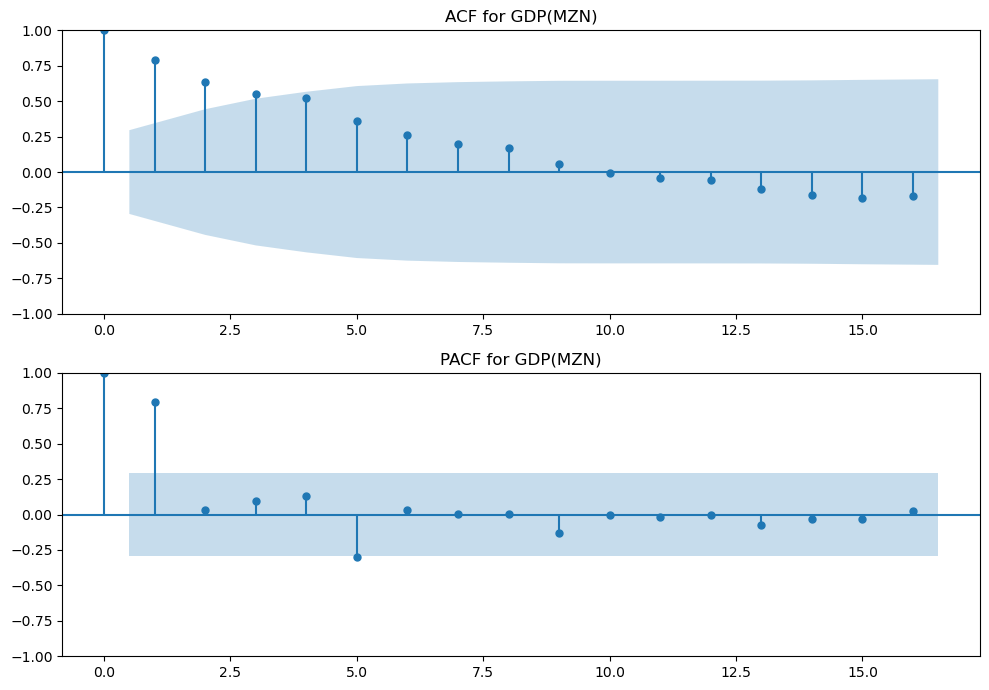

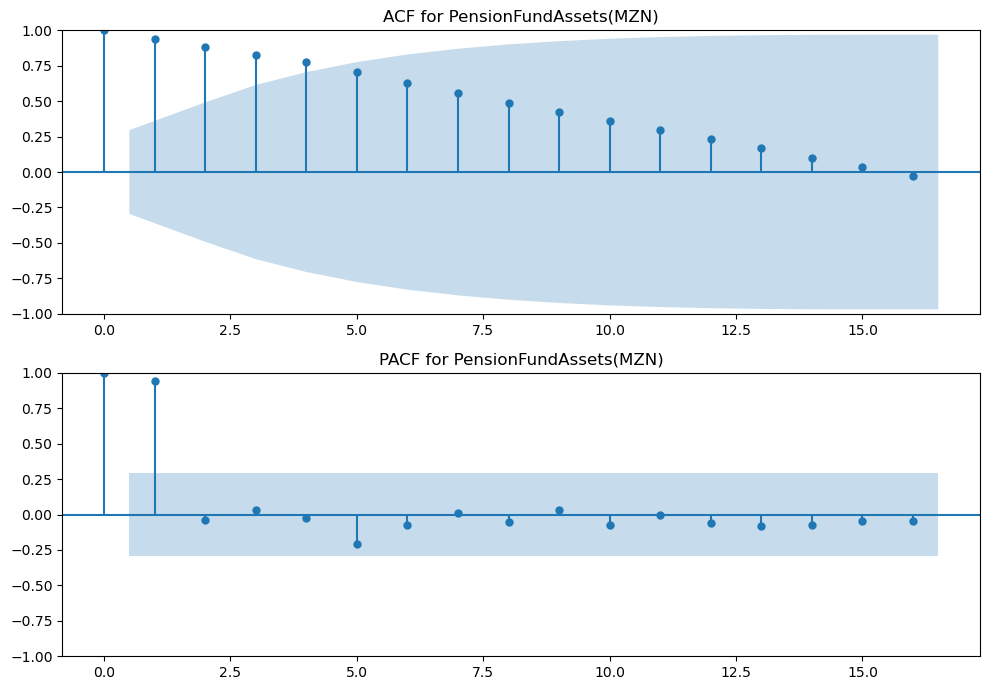

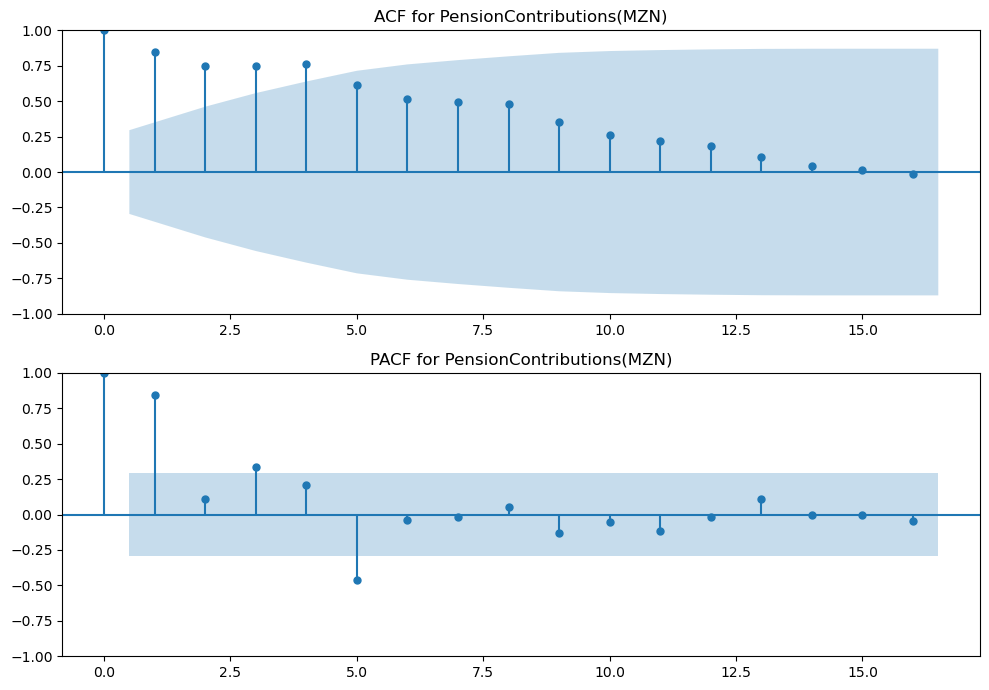

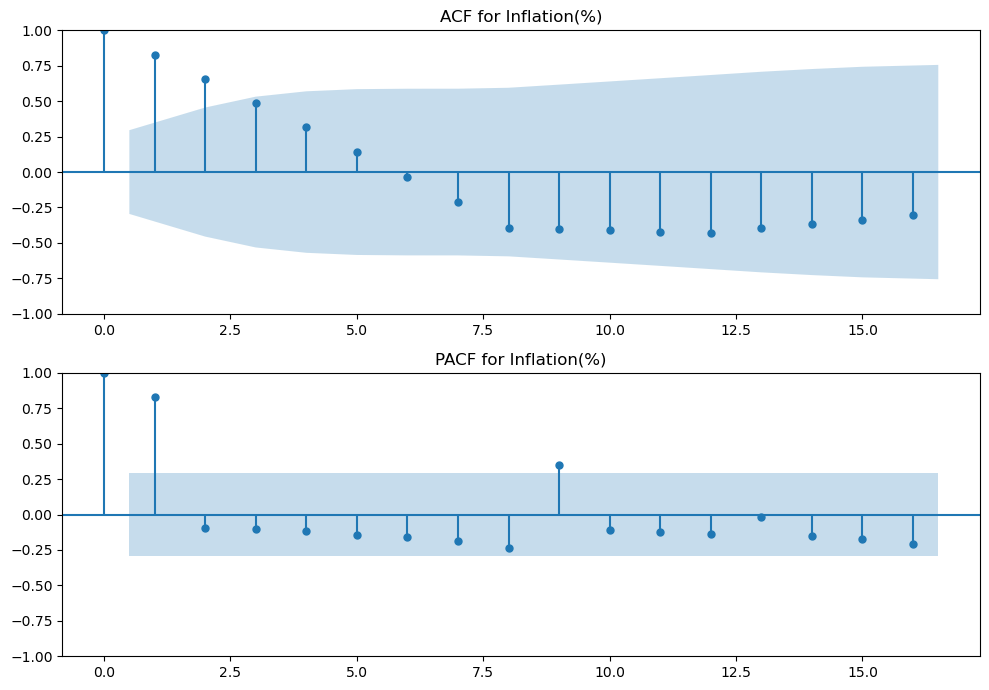

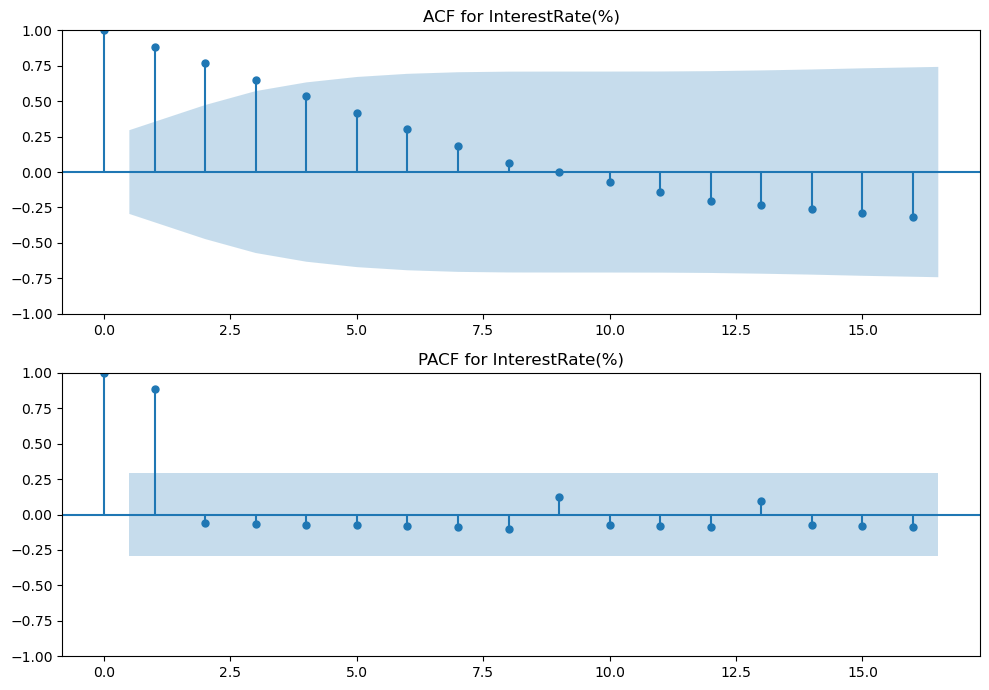

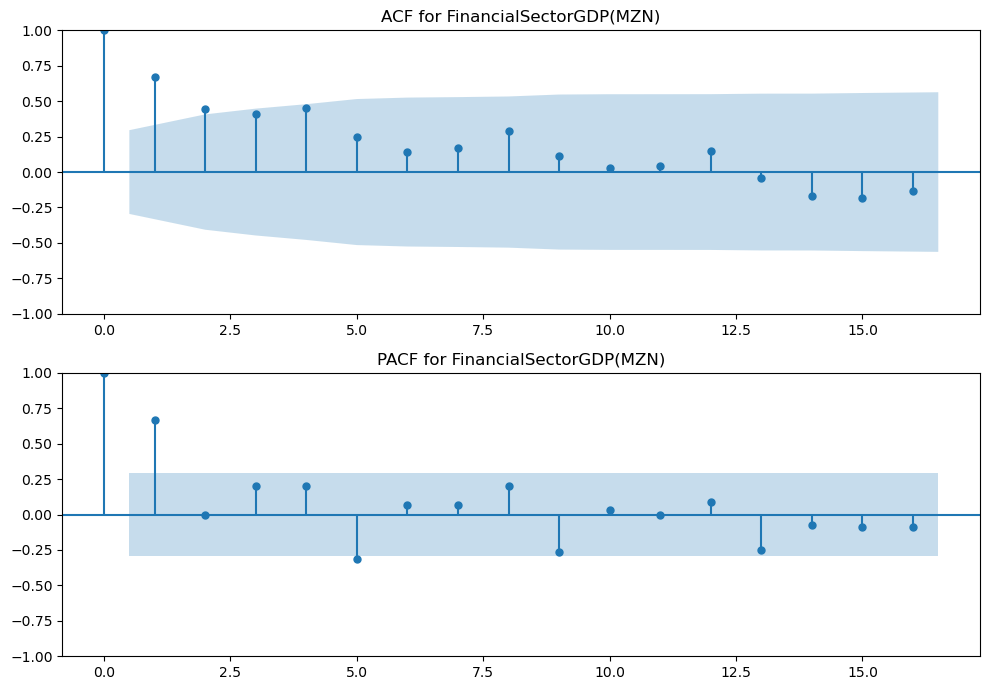

In [ ]:
#10. ACF and PACF plot

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

cols = [
    'GDP(MZN)',
    'PensionFundAssets(MZN)',
    'PensionContributions(MZN)',
    'Inflation(%)',
    'InterestRate(%)',
    'FinancialSectorGDP(MZN)'
]

for col in cols:
    series = df.loc[df.index.year <= 2022, col].dropna()
    fig, axes = plt.subplots(2, 1, figsize=(10, 7))
    plot_acf(series, ax=axes[0], lags=16, title=f"ACF for {col}")
    plot_pacf(series, ax=axes[1], lags=16, title=f"PACF for {col}", method="ywm")
    plt.tight_layout()
    plt.show()



In [ ]:
#11. Construct Lagged Predictor Features for Time-Series ML

# Prepare modeling DataFrame with lagged features (using scaled data, 2012Q2-2022Q4)
df_model = df_scaled.copy()
predictors = ['PensionFundAssets(MZN)', 'PensionContributions(MZN)', 
              'Inflation(%)', 'InterestRate(%)', 'FinancialSectorGDP(MZN)']
for col in predictors:
    df_model[f"{col}_lag1"] = df_model[col].shift(1)
# Drop the first row (2012Q1) which doesn't have lag-1 data
df_model = df_model.dropna()

# Define feature matrix X and target y
X = df_model[[f"{col}_lag1" for col in predictors]]
y = df_model['GDP(MZN)']
print("Lagged feature columns:", X.columns.tolist())
print("Number of samples for modeling:", len(X))


Lagged feature columns: ['PensionFundAssets(MZN)_lag1', 'PensionContributions(MZN)_lag1', 'Inflation(%)_lag1', 'InterestRate(%)_lag1', 'FinancialSectorGDP(MZN)_lag1']
Number of samples for modeling: 43


In [ ]:
#12. Build Regression Models to predict GDP

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Initialize and train models
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

lr_model.fit(X, y)
rf_model.fit(X, y)

# Predictions on the training set
y_pred_lr = lr_model.predict(X)
y_pred_rf = rf_model.predict(X)

# Print R^2 scores for reference
print("Linear Regression R^2:", r2_score(y, y_pred_lr))
print("Random Forest R^2:", r2_score(y, y_pred_rf))
print("Linear model coefficients (for scaled features):", lr_model.coef_)


Linear Regression R^2: 0.7563097562189633
Random Forest R^2: 0.9424805101710071
Linear model coefficients (for scaled features): [ 0.71637095 -0.52973442  0.07369841 -0.27127165  0.86210897]


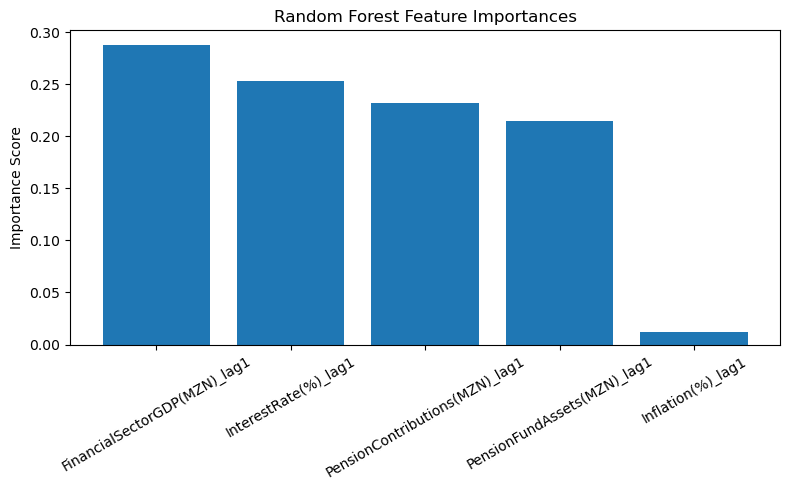

In [ ]:
#13. Plot Feature Importances (Random Forest)

feature_names = X.columns
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,5))
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=30)
plt.title("Random Forest Feature Importances")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

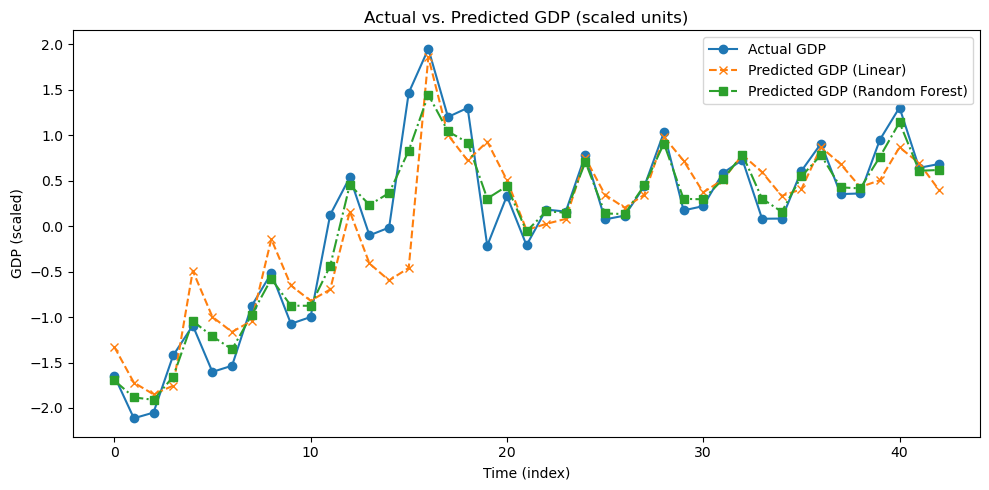

In [ ]:
#13. Plot Actual vs Predicted GDP (scaled) for both models

plt.figure(figsize=(10,5))
plt.plot(y.values, label="Actual GDP", marker='o')
plt.plot(y_pred_lr, label="Predicted GDP (Linear)", linestyle='--', marker='x')
plt.plot(y_pred_rf, label="Predicted GDP (Random Forest)", linestyle='-.', marker='s')
plt.title("Actual vs. Predicted GDP (scaled units)")
plt.xlabel("Time (index)")
plt.ylabel("GDP (scaled)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#14. Error Analysis

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# R² scores
r2_lr = r2_score(y, y_pred_lr)
r2_rf = r2_score(y, y_pred_rf)

# RMSE scores
rmse_lr = np.sqrt(mean_squared_error(y, y_pred_lr))
rmse_rf = np.sqrt(mean_squared_error(y, y_pred_rf))

# MAE scores
mae_lr = mean_absolute_error(y, y_pred_lr)
mae_rf = mean_absolute_error(y, y_pred_rf)

print("Linear Regression R²:  ", r2_lr)
print("Random Forest R²:      ", r2_rf)
print("Linear Regression RMSE:", rmse_lr)
print("Random Forest RMSE:    ", rmse_rf)
print("Linear Regression MAE: ", mae_lr)
print("Random Forest MAE:     ", mae_rf)


Linear Regression R²:   0.7563097562189633
Random Forest R²:       0.9424805101710071
Linear Regression RMSE: 0.4768241114668258
Random Forest RMSE:     0.23165765172718691
Linear Regression MAE:  0.3385726399024051
Random Forest MAE:      0.16966994041559114


In [ ]:
#15. Analyzing the weight of a variable on the model(Linear Regression)

# X_unscaled should use lagged features from your original (unscaled) df!
# y_unscaled should be unscaled GDP

# Example: build lagged features for unscaled data
df_unscaled = df.copy()
for col in ['PensionFundAssets(MZN)', 'PensionContributions(MZN)', 
            'Inflation(%)', 'InterestRate(%)', 'FinancialSectorGDP(MZN)']:
    df_unscaled[f"{col}_lag1"] = df_unscaled[col].shift(1)
df_unscaled = df_unscaled.dropna()

X_unscaled = df_unscaled[[f"{col}_lag1" for col in [
    'PensionFundAssets(MZN)', 'PensionContributions(MZN)', 
    'Inflation(%)', 'InterestRate(%)', 'FinancialSectorGDP(MZN)']]
]
y_unscaled = df_unscaled['GDP(MZN)']

# Fit the model
from sklearn.linear_model import LinearRegression
lr_real = LinearRegression()
lr_real.fit(X_unscaled, y_unscaled)

print("COEFFICIENTS (in real units):")
for name, coef in zip(X_unscaled.columns, lr_real.coef_):
    print(f"{name}: {coef:,.2f} (change in GDP for 1 unit change in {name})")
print("\nIntercept:", lr_real.intercept_)


COEFFICIENTS (in real units):
PensionFundAssets(MZN)_lag1: 10.90 (change in GDP for 1 unit change in PensionFundAssets(MZN)_lag1)
PensionContributions(MZN)_lag1: -69.70 (change in GDP for 1 unit change in PensionContributions(MZN)_lag1)
Inflation(%)_lag1: 306.50 (change in GDP for 1 unit change in Inflation(%)_lag1)
InterestRate(%)_lag1: -1,092.23 (change in GDP for 1 unit change in InterestRate(%)_lag1)
FinancialSectorGDP(MZN)_lag1: 10.56 (change in GDP for 1 unit change in FinancialSectorGDP(MZN)_lag1)

Intercept: 74541.50478952918


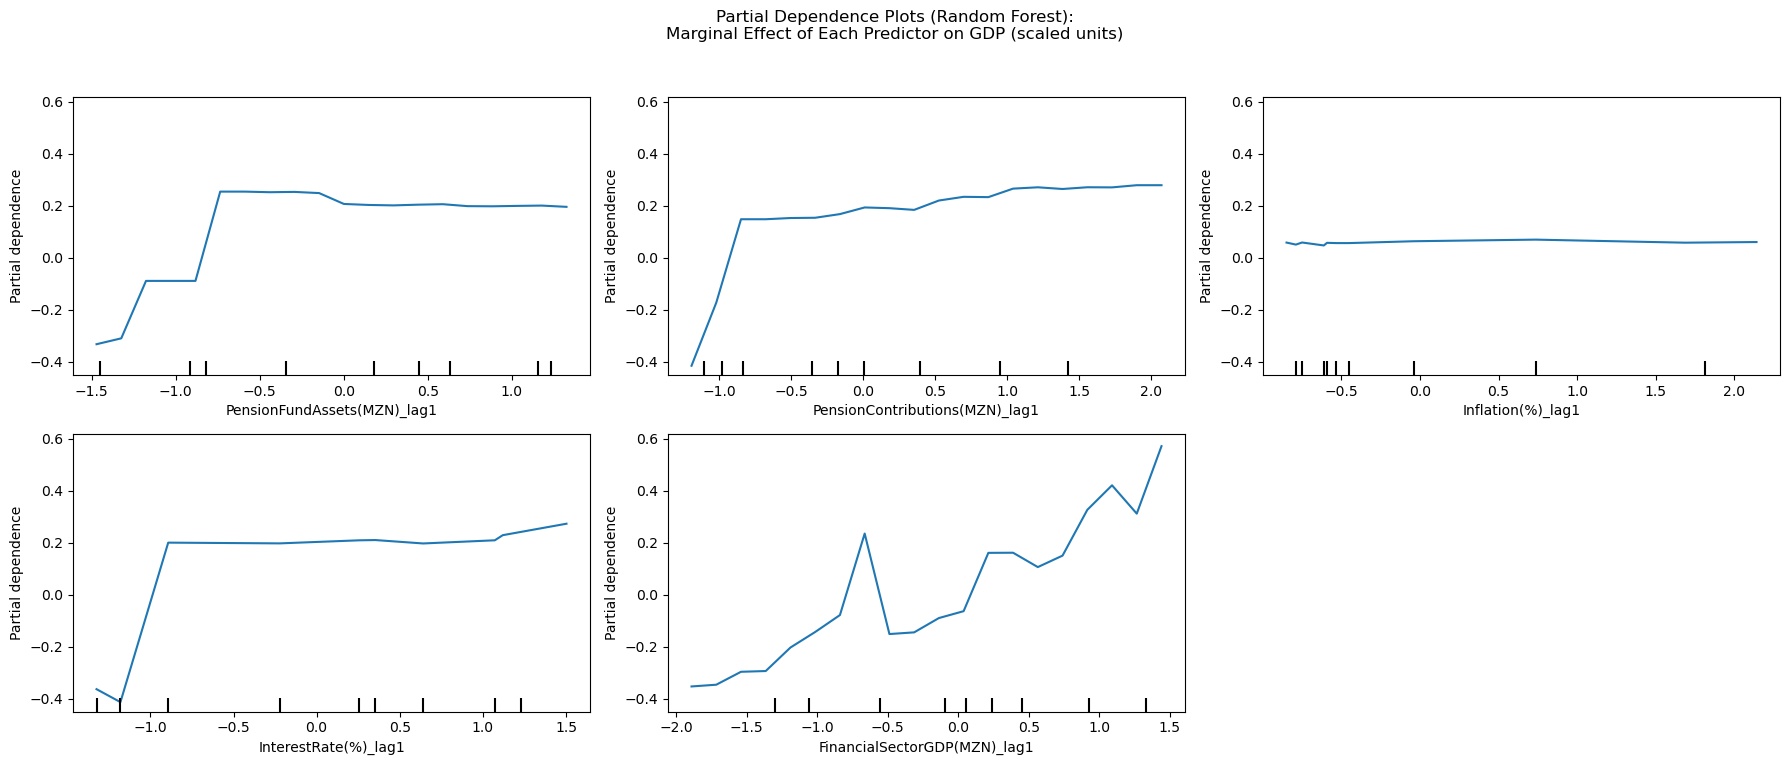

In [ ]:
#16. Analyzing the weight of a variable on the model(Random Forest)

from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import math

# Get all feature indices and names
features_to_plot = list(range(X.shape[1]))
n_features = len(features_to_plot)

# Dynamically set rows/cols (e.g. 3x2 for 5 variables)
n_cols = 3
n_rows = math.ceil(n_features / n_cols)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows))
ax = ax.flatten()  # flatten axes for easy indexing

# Only use as many axes as needed for the features
PartialDependenceDisplay.from_estimator(
    rf_model, X, features=features_to_plot,
    feature_names=X.columns,
    ax=ax[:n_features],
    grid_resolution=20
)

# Hide any unused subplot(s)
for i in range(n_features, len(ax)):
    fig.delaxes(ax[i])

plt.suptitle("Partial Dependence Plots (Random Forest):\nMarginal Effect of Each Predictor on GDP (scaled units)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

